<h1><strong>Start a business in San Francisco</strong></h1>

<h2>Business Problem</h2>
<hr />
<p style="text-align: justify;">In this project, we are going to help our boss to decide what and where should we open our new business in San Francisco. To consider whether is suitable place and type of business for opening, we look into population and also the competitors in such areas.</p>
<p style="text-align: justify;">Firstly, we need to identify the highest population areas (by clustering) in San Francisco.</p>
<p style="text-align: justify;">Secondly, we then check for the most popular types of shop in that certain area</p>
<p style="text-align: justify;">Finally, we can have a high level view by creating a word cloud to see which type of shops is most popular in that area. and we can have our suggestion to our boss.</p>
<p>&nbsp;</p>

<h2>Data Preparation</h2>
<hr />

<h3>Scrape Zipcode and Neighborhood info for San Francisco</h3>

In [27]:
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
# libraries for displaying images
from IPython.display import Image

Solving environment: done

# All requested packages already installed.



In [28]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
from urllib.request import urlopen
from bs4 import BeautifulSoup

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

Solving environment: done

# All requested packages already installed.



In [29]:
url = 'http://www.healthysf.org/bdi/outcomes/zipmap.htm'
html = urlopen(url).read()
soup = BeautifulSoup(html, "html.parser")

In [30]:
table=soup.find_all('table')[2]
df = pd.read_html(str(table),header=0)[1]
SFdf=df[:21]
SFdf.tail()

,Zip Code,Neighborhood,Population (Census 2000)
16,94127,St. Francis Wood/Miraloma/West Portal,20624
17,94131,Twin Peaks-Glen Park,27897
18,94132,Lake Merced,26291
19,94133,North Beach/Chinatown,26827
20,94134,Visitacion Valley/Sunnydale,40134


In [31]:
SFdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 3 columns):
Zip Code                    21 non-null object
Neighborhood                21 non-null object
Population (Census 2000)    21 non-null int64
dtypes: int64(1), object(2)
memory usage: 584.0+ bytes


<h3>Get Geographical Coordinates of Neighborhoods</h3>

In [32]:
address = 'San Francisco, California'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of San Francisco are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of San Francisco are 37.7792808, -122.4192363.


In [33]:
coordinates=[]
for address in SFdf['Zip Code']:
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    coordinates.append([latitude,longitude])

In [34]:
nh_co=pd.DataFrame(coordinates,index=SFdf.index,columns=['latitude','longitude'])
SF_geodata=pd.concat([SFdf, nh_co], axis=1)
SF_geodata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 5 columns):
Zip Code                    21 non-null object
Neighborhood                21 non-null object
Population (Census 2000)    21 non-null int64
latitude                    21 non-null float64
longitude                   21 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 920.0+ bytes


In [35]:
SF_geodata

,Zip Code,Neighborhood,Population (Census 2000),latitude,longitude
0,94102,Hayes Valley/Tenderloin/North of Market,28991,37.779536,-122.418175
1,94103,South of Market,23016,37.774391,-122.411141
2,94107,Potrero Hill,17368,37.793385,-122.407971
3,94108,Chinatown,13716,37.791060,-122.406552
4,94109,Polk/Russian Hill (Nob Hill),56322,37.793803,-122.420583
5,94110,Inner Mission/Bernal Heights,74633,37.753347,-122.416549
6,94112,Ingelside-Excelsior/Crocker-Amazon,73104,37.723791,-122.443466
7,94114,Castro/Noe Valley,30574,37.761300,-122.436787
8,94115,Western Addition/Japantown,33115,37.783939,-122.435298
9,94116,Parkside/Forest Hill,42958,37.746371,-122.472962


we have successfully get the data about the Neighborhood and latitude and longitude for the future part use.



<h3>Get Venues Info in each Neighborhood</h3>
<p>Now we will get Venues Name, Geographical Coordinates, Category by using Foursquare API</p>

In [36]:
# prepare credentails for Foursqure API
CLIENT_ID = 'KMK1PE4FHZKO53I3CAE30QIDE2DOJSNBR013CJNK5MWHFMWL' # your Foursquare ID
CLIENT_SECRET = 'XOW3RMO2P0NS52N0O2MPRW0IGZNWTQWLNCSZ4DREJV3PANR5' # your Foursquare Secret
VERSION = '20180604'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KMK1PE4FHZKO53I3CAE30QIDE2DOJSNBR013CJNK5MWHFMWL
CLIENT_SECRET:XOW3RMO2P0NS52N0O2MPRW0IGZNWTQWLNCSZ4DREJV3PANR5


In [37]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000,LIMIT=30):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()
        venue=results['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue])

    nearby_venues = pd.DataFrame([item for venuel in venues_list for item in venuel])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [38]:
SF_venues = getNearbyVenues(names=SF_geodata['Neighborhood'],
                                   latitudes=SF_geodata['latitude'],
                                   longitudes=SF_geodata['longitude']
                                  )



In [39]:
print(SF_venues.shape)
SF_venues.set_index(SF_venues['Venue Category'])
SF_venues.head()

(630, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hayes Valley/Tenderloin/North of Market,37.779536,-122.418175,Asian Art Museum,37.780178,-122.416505,Art Museum
1,Hayes Valley/Tenderloin/North of Market,37.779536,-122.418175,Louise M. Davies Symphony Hall,37.777976,-122.420157,Concert Hall
2,Hayes Valley/Tenderloin/North of Market,37.779536,-122.418175,Herbst Theater,37.779548,-122.420953,Concert Hall
3,Hayes Valley/Tenderloin/North of Market,37.779536,-122.418175,Philz Coffee,37.781433,-122.417073,Coffee Shop
4,Hayes Valley/Tenderloin/North of Market,37.779536,-122.418175,War Memorial Opera House,37.778601,-122.420816,Opera House


<p>On the above part, we have successfully obtained the places in San Fancisco, and now we move on to analysis data.</p>

<h2>Data Analysis</h2>
<hr />
<p>In the up coming part , we will dive into data for check if there are any insights within.</p>

<h3>Clustering data</h3>

In [40]:
# creating one hot encoding
SF_onehot = pd.get_dummies(SF_venues[['Venue Category']], prefix="", prefix_sep="")
SF_onehot['Neighborhood'] = SF_venues['Neighborhood'] 
SF_onehot.head()

,Accessories Store,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Automotive Shop,...,Trail,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Neighborhood
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Hayes Valley/Tenderloin/North of Market
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Hayes Valley/Tenderloin/North of Market
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Hayes Valley/Tenderloin/North of Market
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Hayes Valley/Tenderloin/North of Market
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Hayes Valley/Tenderloin/North of Market


In [41]:
SF_onehot.shape

(630, 183)

In [42]:
SF_grouped = SF_onehot.groupby('Neighborhood').mean().reset_index()
SF_grouped

,Neighborhood,Accessories Store,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Toy / Game Store,Trail,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Bayview-Hunters Point,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000
1,Castro/Noe Valley,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.033333,0.000000,0.033333
2,Chinatown,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000
3,Haight-Ashbury,0.033333,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.033333,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.000000,0.000000,0.033333
4,Hayes Valley/Tenderloin/North of Market,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Ingelside-Excelsior/Crocker-Amazon,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.033333,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000
6,Inner Mission/Bernal Heights,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333
7,Inner Richmond,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Lake Merced,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333
9,Marina,0.033333,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.066667,0.000000,0.000000,0.066667


In [43]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [46]:
# dataframe for top 10 venues

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
SF_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
SF_neighborhoods_venues_sorted['Neighborhood'] = SF_grouped['Neighborhood']

SF_neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bayview-Hunters Point,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Castro/Noe Valley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Chinatown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Haight-Ashbury,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Hayes Valley/Tenderloin/North of Market,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Ingelside-Excelsior/Crocker-Amazon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Inner Mission/Bernal Heights,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Inner Richmond,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Lake Merced,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Marina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:

for ind in np.arange(SF_grouped.shape[0]):
    SF_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(SF_grouped.iloc[ind, :], num_top_venues)

SF_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bayview-Hunters Point,Coffee Shop,Park,Mexican Restaurant,Brewery,Furniture / Home Store,Nightclub,Music Venue,Pet Store,Deli / Bodega,Café
1,Castro/Noe Valley,Coffee Shop,Wine Bar,Yoga Studio,Mediterranean Restaurant,Salon / Barbershop,Clothing Store,Pizza Place,Optical Shop,Cycle Studio,Deli / Bodega
2,Chinatown,Coffee Shop,Boutique,Hotel,Bubble Tea Shop,French Restaurant,Electronics Store,Kitchen Supply Store,Spa,Southern / Soul Food Restaurant,Men's Store
3,Haight-Ashbury,Bookstore,Breakfast Spot,Coffee Shop,Yoga Studio,Gift Shop,Record Shop,Park,Organic Grocery,Mexican Restaurant,Jazz Club
4,Hayes Valley/Tenderloin/North of Market,Coffee Shop,Concert Hall,Performing Arts Venue,Vegetarian / Vegan Restaurant,Cocktail Bar,Beer Bar,Theater,Sandwich Place,Bookstore,Southern / Soul Food Restaurant


In [48]:
# will start by running k-means to cluster the neighborhood into 5 clusters.

kclusters = 5

SF_grouped_clustering = SF_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(SF_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 2, 4, 2, 2, 3, 2, 3, 3, 2], dtype=int32)

<h3>Combine population data to geodata</h3>

In [53]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

# add clustering labels
SF_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

SF_merged = SF_geodata

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
SF_merged = SF_merged.join(SF_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how = 'right')

SF_merged

,Zip Code,Neighborhood,Population (Census 2000),latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,94102,Hayes Valley/Tenderloin/North of Market,28991,37.779536,-122.418175,2,Coffee Shop,Concert Hall,Performing Arts Venue,Vegetarian / Vegan Restaurant,Cocktail Bar,Beer Bar,Theater,Sandwich Place,Bookstore,Southern / Soul Food Restaurant
1,94103,South of Market,23016,37.774391,-122.411141,2,Coffee Shop,Marijuana Dispensary,Dance Studio,Wine Bar,Nightclub,Café,Motorcycle Shop,Cocktail Bar,Clothing Store,Brewery
2,94107,Potrero Hill,17368,37.793385,-122.407971,4,Coffee Shop,Hotel,Bubble Tea Shop,Szechuan Restaurant,Japanese Curry Restaurant,Burger Joint,Mediterranean Restaurant,Men's Store,Latin American Restaurant,French Restaurant
3,94108,Chinatown,13716,37.791060,-122.406552,4,Coffee Shop,Boutique,Hotel,Bubble Tea Shop,French Restaurant,Electronics Store,Kitchen Supply Store,Spa,Southern / Soul Food Restaurant,Men's Store
4,94109,Polk/Russian Hill (Nob Hill),56322,37.793803,-122.420583,1,Deli / Bodega,Wine Bar,Gym / Fitness Center,Gym,Steakhouse,Italian Restaurant,Boutique,Sushi Restaurant,Massage Studio,Seafood Restaurant
5,94110,Inner Mission/Bernal Heights,74633,37.753347,-122.416549,2,Fish Market,Mexican Restaurant,Performing Arts Venue,Bookstore,Yoga Studio,Dessert Shop,Burrito Place,Clothing Store,Cocktail Bar,Coffee Shop
6,94112,Ingelside-Excelsior/Crocker-Amazon,73104,37.723791,-122.443466,3,Mexican Restaurant,Park,Sandwich Place,Pizza Place,Filipino Restaurant,Latin American Restaurant,Bubble Tea Shop,Burger Joint,Burrito Place,College Gym
7,94114,Castro/Noe Valley,30574,37.761300,-122.436787,2,Coffee Shop,Wine Bar,Yoga Studio,Mediterranean Restaurant,Salon / Barbershop,Clothing Store,Pizza Place,Optical Shop,Cycle Studio,Deli / Bodega
8,94115,Western Addition/Japantown,33115,37.783939,-122.435298,1,Bakery,New American Restaurant,Indian Restaurant,Bubble Tea Shop,Spa,Bookstore,Fried Chicken Joint,Boutique,Breakfast Spot,Burger Joint
9,94116,Parkside/Forest Hill,42958,37.746371,-122.472962,1,Bakery,Chinese Restaurant,Sandwich Place,Yoga Studio,Ice Cream Shop,Pizza Place,Pharmacy,Park,Optical Shop,Mediterranean Restaurant


<h3>Map for Visual insights</h3>

In [54]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(SF_merged['latitude'], SF_merged['longitude'], SF_merged['Neighborhood'], SF_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h3>Population Distribution of each clusters</h3>

As now we have a couple of clusters which have different characters, we are now looking for those with most population for best to start our business.

In [55]:
SF_merged_grouped_population = SF_merged.filter(['Cluster Labels','Population (Census 2000)'], axis=1)
SF_merged_grouped_population.set_index(SF_merged_grouped_population['Cluster Labels'])
SF_merged_grouped_population2 = SF_merged_grouped_population.groupby('Cluster Labels').sum()

SF_merged_grouped_population2 .sort_values(by=['Population (Census 2000)'], inplace=True, ascending=False)

SF_merged_grouped_population2 


,Population (Census 2000)
Cluster Labels,
2,294971
3,239535
1,174868
4,31084
0,26827


Above shows that more that half of the population lives in cluster 2 and 3. Thus, we are going to further look into them.

<h4>Cluster 2</h4>

In [57]:
SF_merged.loc[SF_merged['Cluster Labels'] == 2, SF_merged.columns[[1] + list(range(5, SF_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hayes Valley/Tenderloin/North of Market,2,Coffee Shop,Concert Hall,Performing Arts Venue,Vegetarian / Vegan Restaurant,Cocktail Bar,Beer Bar,Theater,Sandwich Place,Bookstore,Southern / Soul Food Restaurant
1,South of Market,2,Coffee Shop,Marijuana Dispensary,Dance Studio,Wine Bar,Nightclub,Café,Motorcycle Shop,Cocktail Bar,Clothing Store,Brewery
5,Inner Mission/Bernal Heights,2,Fish Market,Mexican Restaurant,Performing Arts Venue,Bookstore,Yoga Studio,Dessert Shop,Burrito Place,Clothing Store,Cocktail Bar,Coffee Shop
7,Castro/Noe Valley,2,Coffee Shop,Wine Bar,Yoga Studio,Mediterranean Restaurant,Salon / Barbershop,Clothing Store,Pizza Place,Optical Shop,Cycle Studio,Deli / Bodega
10,Haight-Ashbury,2,Bookstore,Breakfast Spot,Coffee Shop,Yoga Studio,Gift Shop,Record Shop,Park,Organic Grocery,Mexican Restaurant,Jazz Club
13,Sunset,2,Sandwich Place,Vietnamese Restaurant,Chinese Restaurant,Sushi Restaurant,Coffee Shop,Liquor Store,Ethiopian Restaurant,Dumpling Restaurant,Korean Restaurant,Japanese Restaurant
14,Marina,2,Spa,Italian Restaurant,Yoga Studio,Wine Bar,Steakhouse,Ice Cream Shop,Pet Store,Park,Mexican Restaurant,Liquor Store
16,St. Francis Wood/Miraloma/West Portal,2,Coffee Shop,Wine Bar,Italian Restaurant,Comic Shop,Park,Nail Salon,Movie Theater,Mexican Restaurant,Mediterranean Restaurant,Gym / Fitness Center


<h4>Cluster 3</h4>

In [58]:
SF_merged.loc[SF_merged['Cluster Labels'] == 3, SF_merged.columns[[1] + list(range(5, SF_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Ingelside-Excelsior/Crocker-Amazon,3,Mexican Restaurant,Park,Sandwich Place,Pizza Place,Filipino Restaurant,Latin American Restaurant,Bubble Tea Shop,Burger Joint,Burrito Place,College Gym
11,Inner Richmond,3,Park,Café,Garden,Coffee Shop,Bakery,Korean Restaurant,Accessories Store,Burger Joint,Flower Shop,Caribbean Restaurant
15,Bayview-Hunters Point,3,Coffee Shop,Park,Mexican Restaurant,Brewery,Furniture / Home Store,Nightclub,Music Venue,Pet Store,Deli / Bodega,Café
17,Twin Peaks-Glen Park,3,Scenic Lookout,Trail,Bus Stop,Light Rail Station,Theater,Playground,Burger Joint,Burrito Place,Café,Lake
18,Lake Merced,3,Café,Mexican Restaurant,Rental Car Location,Park,Pizza Place,Light Rail Station,Snack Place,Burger Joint,Sandwich Place,Yoga Studio
20,Visitacion Valley/Sunnydale,3,Grocery Store,Café,Park,Sandwich Place,Trail,Asian Restaurant,Fried Chicken Joint,Liquor Store,Marijuana Dispensary,Market


we have just isted out the commonn venues of the two clusters, but seems it is not easy for read. thus we move on to create Word clouds for more analysis.

<h4>Import pyplot library</h4>

In [59]:
import matplotlib.pyplot as plt

In [60]:
# install wordcloud
!conda install -c conda-forge wordcloud==1.4.1 --yes

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - wordcloud==1.4.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    wordcloud-1.4.1            |           py35_0         324 KB  conda-forge

The following NEW packages will be INSTALLED:

    wordcloud: 1.4.1-py35_0 conda-forge


wordcloud-1.4.1      | 324 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Wordcloud is installed and imported!


In [61]:
stopwords = set(STOPWORDS)

In [65]:
# instantiate a word cloud object
SF_wc = WordCloud(
    background_color='Black',
    max_words=2000,
    stopwords=stopwords
)

SF_merged_c2 = SF_merged.loc[SF_merged['Cluster Labels'] ==2, SF_merged.columns[[1] + list(range(5, SF_merged.shape[1]))]]

# generate the word cloud
SF_wc.generate(str(SF_merged_c2))

<p><strong>Cluster 2</strong></p>

As below shown, in cluster 2, it is obverse that restaurant, Cofffee shop , Mexican and Common Venue(will be omitted as not representing any type of business)

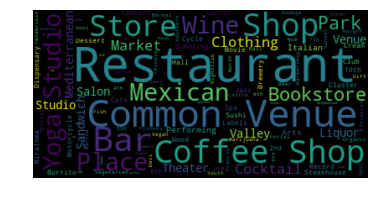

In [66]:
# display the word cloud
plt.imshow(SF_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

<p><strong>Cluster 3</strong></p>

As below shown, in cluster 3, it is obverse that restaurant, Cafe , Mexican and Common Venue...(will be omitted as not representing any type of business)

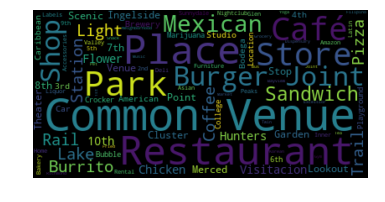

In [67]:
# instantiate a word cloud object
SF_wc = WordCloud(
    background_color='Black',
    max_words=2000,
    stopwords=stopwords
)

SF_merged_c3 = SF_merged.loc[SF_merged['Cluster Labels'] == 3, SF_merged.columns[[1] + list(range(5, SF_merged.shape[1]))]]

# generate the word cloud
SF_wc.generate(str(SF_merged_c3))

plt.imshow(SF_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

<p><strong>All Cluster</strong></p>

besiedes, the two clusters, we  also look into overall.

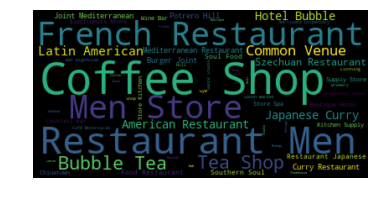

In [69]:
# instantiate a word cloud object
SF_wc = WordCloud(
    background_color='Black',
    max_words=2000,
    stopwords=stopwords
)

SF_merged_All = SF_merged.loc[SF_merged['Cluster Labels'] , SF_merged.columns[[1] + list(range(5, SF_merged.shape[1]))]]

# generate the word cloud
SF_wc.generate(str(SF_merged_All))

plt.imshow(SF_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

<h2>Conclusion</h2>
<hr />

To conclude, we have look the overall popular shops in San Francisco, seems people in here are enjoy Coffee/Cafe and restaurant (especially French). 

We have notice that amount the clusters, cluster 3 is with the least popular Coffee shop/café, especially in the area of “Ingelside-Excelsior/Crocker-Amazon”.

We suggest open a Coffee Shop/ Café in area of “Ingelside-Excelsior/Crocker-Amazon”.
